## Decision Trees and Ensemble Models in classification and regression problems.

In [ ]:
#required imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from time import time

In [ ]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


After installing the necessary libraries, proceed to download the data. Since reading the excel file won't create headers by default, we added two more operations to substitute the columns.

In [ ]:
#loading the data
dataset = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",header=1)
#dataset.columns = dataset.iloc[0]
#dataset.drop(['ID'], inplace=True)

In the following, you can take a look into the dataset.

In [ ]:
dataset.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
cc_df=dataset.copy()

In [ ]:
tmp=cc_df.loc[:,'SEX': 'PAY_6'].agg(['count','unique'])
tmp

,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,"[2, 1]","[2, 1, 3, 5, 4, 6, 0]","[1, 2, 3, 0]","[24, 26, 34, 37, 57, 29, 23, 28, 35, 51, 41, 3...","[2, -1, 0, -2, 1, 3, 4, 8, 7, 5, 6]","[2, 0, -1, -2, 3, 5, 7, 4, 1, 6, 8]","[-1, 0, 2, -2, 3, 4, 6, 7, 1, 5, 8]","[-1, 0, -2, 2, 3, 4, 5, 7, 6, 1, 8]","[-2, 0, -1, 2, 3, 5, 4, 7, 8, 6]","[-2, 2, 0, -1, 3, 6, 4, 7, 8, 5]"


In [ ]:
cc_df['default payment next month'].value_counts()/len(cc_df) *100

0    77.88
1    22.12
Name: default payment next month, dtype: float64

In [ ]:
categorical_vars=['EDUCATION','MARRIAGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Discrete_vars=['AGE','LIMIT_BAL','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Target_var=['default payment next month']

In [ ]:
#std_discrete_vars are more suitable for the standard scalar transformation
std_discrete_vars=['AGE','LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
# mm_discrete_vars are more suitable for the min max transformation
mm_discrete_vars=['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [ ]:
#mar_edu baseEstimator class to implement a custom function to transform the education and marriage column into correct categories.
from sklearn.base import BaseEstimator, TransformerMixin #classes to inherit from when building custom transformers
class mar_edu(BaseEstimator, TransformerMixin):
    def __init__(self,val=[]):
        self.val=val
        
    def fit(self, X, y=None):
        if (len(self.val[0]) > 0):
            X=self.edu_mar_trans(X)
        return self
   
    def edu_mar_trans(self, X,y=None):
        X[self.val[0]]=X[self.val[0]].map(lambda x: 4 if (x<1 or x>4) else x)
        X[self.val[1]]=X[self.val[1]].map(lambda t: 3 if (t<1) else t)
        return X
    
    def transform(self, X,y=None):
        X[self.val[0]]=X[self.val[0]].map(lambda x: 4 if (x<1 or x>4) else x)
        X[self.val[1]]=X[self.val[1]].map(lambda t: 3 if (t<1) else t)
        return X

In [ ]:
X=cc_df[categorical_vars+Discrete_vars]
y=cc_df[Target_var]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (24000, 22)
X_test.shape: (6000, 22)
y_train.shape: (24000, 1)
y_test.shape: (6000, 1)


In [ ]:
#creating pre processors for discrete and categorical variables. 
preprocessor = make_column_transformer(
    (StandardScaler(),std_discrete_vars),
    (MinMaxScaler(),mm_discrete_vars),
    (OneHotEncoder(), categorical_vars))

In [ ]:
#The pipeline is designed to first custom transform the education and marriage variables and then apply the transformations on the 
#discrete and categorical variables as designed in preprocessors.
pipe_full=Pipeline([
    ('edu_mar_trans',mar_edu(val=['EDUCATION','MARRIAGE'])),
    ('cat_dis',preprocessor)])

In [ ]:
pipe_full.fit(X_train,y_train)

Pipeline(steps=[('edu_mar_trans', mar_edu(val=['EDUCATION', 'MARRIAGE'])),
                ('cat_dis',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['AGE', 'LIMIT_BAL',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('onehotencoder',
                               

In [ ]:
X_train_transformed = pipe_full.transform(X_train)
X_test_transformed = pipe_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (24000, 85)
X_test_transformed.shape: (6000, 85)


### <font color='blue'>Applying Decision tree model on the X_train_transformed with settings as below:</font>
DecisionTreeClassifier(max_depth=5, criterion='entropy')

---



In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=5, criterion='entropy',random_state=123)
tree_clf.fit(X_train_transformed,np.ravel(y_train))

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=123)

In [ ]:
#using the decision tree classifier, predicting target values with test data
y_predict = tree_clf.predict(X_test_transformed) 

Test accuracy for Decision tree Classifier: 81.78 %


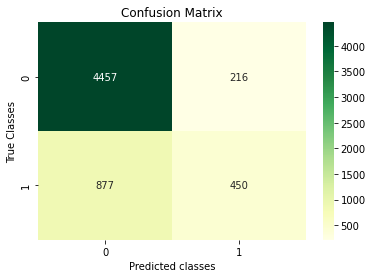

In [ ]:
# Plotting confusion matrix
print('Test accuracy for Decision tree Classifier:'\
      , round(accuracy_score(y_test,y_predict)*100, 2), '%')
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test,y_predict), annot=True, cmap="YlGn",fmt="d")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

### <font color='blue'>Applying Decision tree model on the X_train_transformed with different settings as below:</font>
DecisionTreeClassifier(max_depth=5, criterion='gini')

In [ ]:
tree_clf2 = DecisionTreeClassifier(max_depth=5, criterion='gini',random_state=123)
tree_clf2.fit(X_train_transformed,np.ravel(y_train))

DecisionTreeClassifier(max_depth=5, random_state=123)

In [ ]:
#using the decision tree classifier, predicting target values with test data
y_predict2 = tree_clf2.predict(X_test_transformed)

Test accuracy for Decision tree Classifier: 81.88 %


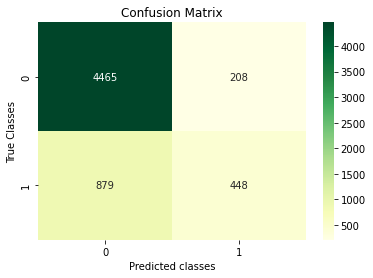

In [ ]:
# Plotting confusion matrix
print('Test accuracy for Decision tree Classifier:'\
      , round(accuracy_score(y_test,y_predict2)*100, 2), '%')
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test,y_predict2), annot=True, cmap="YlGn",fmt="d")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

###<font color='blue'>Analysis</font>

In [ ]:
def analysis_report(y_test,y_pred,text_mod):

  CM=confusion_matrix(y_test,y_pred)
  senstivity=CM[1,1]/(CM[1,1]+CM[1,0])
  precision=CM[1,1]/(CM[1,1]+CM[0,1])
  f_score=(2*(senstivity*precision))/(senstivity+precision)
  title='Confusion Matrix of '+ text_mod
  print(title+": \n {}".format(CM))
  print("Accuracy:"\
      ,round(accuracy_score(y_test,  y_pred)*100,3),'%')
  print("Recall/Sensitivity/True Positive Rate:",round(senstivity,4))
  print("Precision:",round(precision,4))
  print('F1 score:',round(f_score,3))

In [ ]:
analysis_report(y_test,y_predict,'criterion=entropy')

Confusion Matrix of criterion=entropy: 
 [[4457  216]
 [ 877  450]]
Accuracy: 81.783 %
Recall/Sensitivity/True Positive Rate: 0.3391
Precision: 0.6757
F1 score: 0.452


In [ ]:
analysis_report(y_test,y_predict2,'criterion=gini')

Confusion Matrix of criterion=gini: 
 [[4465  208]
 [ 879  448]]
Accuracy: 81.883 %
Recall/Sensitivity/True Positive Rate: 0.3376
Precision: 0.6829
F1 score: 0.452


The Decision tree classifier with the Gini impurity criteria seemed to have given a better accuracy. For the purpose of consistent comparison, max depth was kept 5 for both models. In repeated trials and tests, decreasing or increasing max_depth always resulted in decreased accuracy. 

However criterion='entropy' gives a slightly higher recall.For this scenario, a high recall and precision both are very important.As both higher false negative rate or false positive rate may result a huge loss to the bank. In case of wrongly predicting a non defaulting customer as a defaulter, bank may end up loosing valuable customers of future and in case of wrongly predicting a defaulter a non defaulter may cause the bank to default it self.

Therefore the best model should be more concerned with correct prediction of minority class i.e. default next month=1. Therefore the settings on entropy performed better. 

#### Building the same decision tree but this time by RandomizedSearchCV over hyper-parameters and result comparisons.

In [ ]:
dec_tree = DecisionTreeClassifier(random_state=123)
param_dist = {"max_depth": [3,5,10,15,20],
              "max_features": ['auto', 'sqrt', 'log2'],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["gini", "entropy"],
              'splitter': ['best', 'random']}

In [ ]:
tree_cv = RandomizedSearchCV(dec_tree, param_dist, cv=StratifiedKFold(n_splits=5),verbose=2, random_state=35, n_jobs = -1)

In [ ]:
tree_cv.fit(X_train_transformed,np.ravel(y_train))

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score of cross validation is {}".format(round(tree_cv.best_score_,4)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned Decision Tree Parameters: {'splitter': 'best', 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini'}
Best score of cross validation is 0.8128


In [ ]:
tree_cv.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=6,
                       random_state=123)

In [ ]:
y_predict_RS=tree_cv.best_estimator_.predict(X_test_transformed)

Test accuracy for Decision tree Classifier using Randomised Searchcv: 81.82 %


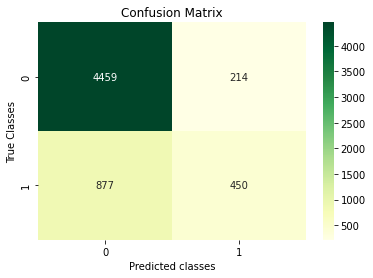

In [ ]:
# Plotting confusion matrix
print('Test accuracy for Decision tree Classifier using Randomised Searchcv:'\
      , round(accuracy_score(y_test,y_predict_RS)*100, 2), '%')
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test,y_predict_RS), annot=True, cmap="YlGn",fmt="d")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
analysis_report(y_test,y_predict_RS,'Randomised searchcv')

Confusion Matrix of Randomised searchcv: 
 [[4459  214]
 [ 877  450]]
Accuracy: 81.817 %
Recall/Sensitivity/True Positive Rate: 0.3391
Precision: 0.6777
F1 score: 0.452


### <font color='blue'>Analysis</font>
The best estimator from the randomised search cv for decision tree classifier was as below:<br>
DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=6,
                       random_state=123,criterion='gini')<br>

If we compare the results with the decision tree before with criterion='gini', after Randomised Search cv, the model accuracy has gone down a bit but we get a slightly better Recall and a little lower precision. Again the difference in both models is very insignificant as f1 scores are same. 


#### Now building same classifier by using following ensemble models. For each of these models calculate accuracy and plot the learning curves.

* Random Forest 
* AdaBoost
* Extra Trees Classifier 
* Gradient Boosted Trees 


##<font color='blue'>Random Forest & Extra Trees Classifier</font>

---



In [ ]:
search_param = {'n_estimators':[10,25,50,100,200],
                "max_depth": [3,5,10,15,20,50],
              "max_features": ['auto', 'sqrt', 'log2'],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["gini", "entropy"],
              'bootstrap':'True',
              'oob_score':'True'}

In [ ]:
rnd_clf = RandomForestClassifier(random_state=123)
ext_clf= ExtraTreesClassifier(random_state=123)

In [ ]:
rnd_clf_cv = RandomizedSearchCV(rnd_clf, search_param, cv=StratifiedKFold(n_splits=5),verbose=2, random_state=35, n_jobs = -1)
ext_clf_cv = RandomizedSearchCV(ext_clf, search_param, cv=StratifiedKFold(n_splits=5),verbose=2, random_state=35, n_jobs = -1)

In [ ]:
%%time
start_time=time()
rnd_clf_cv.fit(X_train_transformed,np.ravel(y_train))
timing_rnd=time()-start_time

start_time=time()
ext_clf_cv.fit(X_train_transformed,np.ravel(y_train))
timing_ext=time()-start_time

print('Random Forest processing time : '+str(round(timing_rnd/60,2))+' minutes')
print(rnd_clf_cv.best_estimator_)

print('Extra Tree processing time : '+str(round(timing_ext/60,2))+' minutes')
print(ext_clf_cv.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest processing time : 4.68 minutes
RandomForestClassifier(bootstrap='T', max_depth=50, min_samples_leaf=5,
                       oob_score='T', random_state=123)
Extra Tree processing time : 2.16 minutes
ExtraTreesClassifier(bootstrap='u', max_depth=50, min_samples_leaf=8,
                     n_estimators=50, oob_score='T', random_state=123)
CPU times: user 28.9 s, sys: 381 ms, total: 29.3 s
Wall time: 6min 50s


In [ ]:

y_pred_RF = rnd_clf_cv.best_estimator_.predict(X_test_transformed)
print('Test accuracy for Random Forest Classifier using Randomised Searchcv:'\
      ,round(accuracy_score(y_test, y_pred_RF)*100,3),'%')

Test accuracy for Random Forest Classifier using Randomised Searchcv: 82.067 %


In [ ]:

y_pred_EXT = ext_clf_cv.best_estimator_.predict(X_test_transformed)
print('Test accuracy for Extra Tree Classifier using Randomised Searchcv:'\
      ,round(accuracy_score(y_test, y_pred_EXT)*100,3),'%')

Test accuracy for Extra Tree Classifier using Randomised Searchcv: 82.133 %


##<font color='blue'>Ada Boost Classifier</font>

In [ ]:
#Running Ada Boost classifier on the decision tree with best hyperparameters found from Q-2
ada_clf3 = AdaBoostClassifier(
    tree_cv.best_estimator_, n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf3.fit(X_train_transformed,np.ravel(y_train))
y_pred_ada3 = ada_clf3.predict(X_test_transformed)
print('Test accuracy for Ada Boost classifier on the decision tree with best hyperparameters:'\
      ,round(accuracy_score(y_test, y_pred_ada3)*100,3),'%')

Test accuracy for Ada Boost classifier on the decision tree with best hyperparameters: 80.133 %


## <font color='blue'>Gradient Boosted Trees</font>

In [ ]:
search_param = {'loss':['deviance','exponential'],
                "max_depth": [3,5,10,15,20,50],
                'n_estimators':[10,25,50,100,200],
                "learning_rate": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
              "max_features": ['auto', 'sqrt', 'log2'],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ['friedman_mse','squared_error']}

In [ ]:
GB_clf=GradientBoostingClassifier(random_state=123)
GB_clf_cv = RandomizedSearchCV(GB_clf, search_param, cv=StratifiedKFold(n_splits=5),verbose=2, random_state=35, n_jobs = -1)

In [ ]:
GB_clf_cv.fit(X_train_transformed,np.ravel(y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=GradientBoostingClassifier(random_state=123),
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1.0],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 10, 15, 20, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],


In [ ]:
y_pred_GB = GB_clf_cv.best_estimator_.predict(X_test_transformed)
print('Test accuracy for Gradient Boosted Tree Classifier using Randomised Searchcv:'\
      ,round(accuracy_score(y_test, y_pred_GB)*100,3),'%')

Test accuracy for Gradient Boosted Tree Classifier using Randomised Searchcv: 81.833 %


##<font color='blue'>Learning curves</font>

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  axes[0].set_title(title)
  if ylim is not None:
      axes[0].set_ylim(*ylim)
      axes[0].set_xlabel("Training examples")
      axes[0].set_ylabel("Score")

  train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  fit_times_mean = np.mean(fit_times, axis=1)
  fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
  axes[0].grid()
  axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
  axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
  axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
  axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
  axes[0].legend(loc="best")
  fig.subplots_adjust(wspace=0.3)

  # Plot fit_time vs score
  fit_time_argsort = fit_times_mean.argsort()
  fit_time_sorted = fit_times_mean[fit_time_argsort]
  test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
  test_scores_std_sorted = test_scores_std[fit_time_argsort]
  axes[1].grid()
  axes[1].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
  axes[1].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1)
  axes[1].set_xlabel("fit_times")
  axes[1].set_ylabel("Score")
  axes[1].set_title("Performance of the model")
  
  return plt

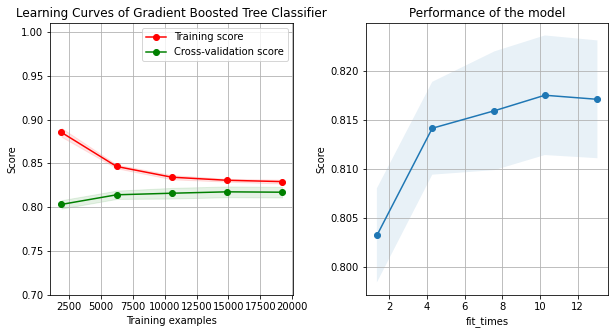

In [ ]:


title = "Learning Curves of Gradient Boosted Tree Classifier"
plot_learning_curve(
    GB_clf_cv.best_estimator_, title, X_train_transformed,np.ravel(y_train), ylim=(0.7, 1.01), cv=StratifiedKFold(n_splits=5), n_jobs=4
);

From the learning curve, Gradient boost classifier seems to have performed great. The fact that with more and more training samples, the training score and validation score tends to converge. Also we can see the how the model performance improves with the score improvement.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

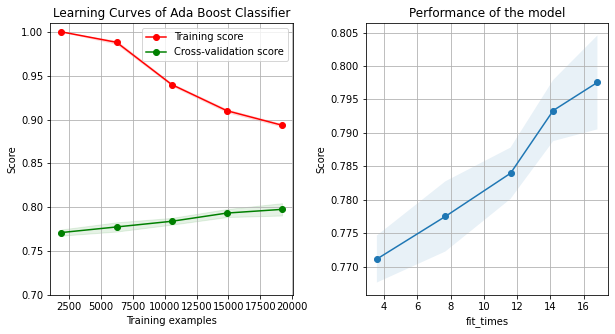

In [ ]:
title = "Learning Curves of Ada Boost Classifier"
plot_learning_curve(
    ada_clf3, title, X_train_transformed,np.ravel(y_train), ylim=(0.7, 1.01), cv=StratifiedKFold(n_splits=5), n_jobs=4
)

Ada Boost classifier tends to underfit at smaller training samples as the training score is way higher than the validation score. The learning curves however show that this difference tends to converge but it requires more training samples and thats why we see that the model performance keeps on increasing. This model will perform better with bigger training samples. With the present training samples, it tends to underfit.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

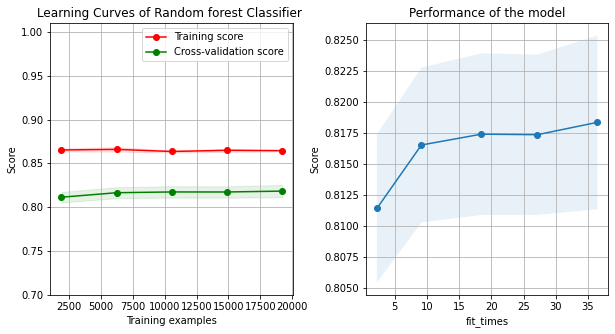

In [ ]:
title = "Learning Curves of Random forest Classifier "
plot_learning_curve(
    rnd_clf_cv.best_estimator_, title, X_train_transformed,np.ravel(y_train), ylim=(0.7, 1.01), cv=StratifiedKFold(n_splits=5), n_jobs=4
)

The flat lines of the training score and validation score shows that clearly the Random Forest model was unable to learn throughout the training process. We can say its also a case of underfitting.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

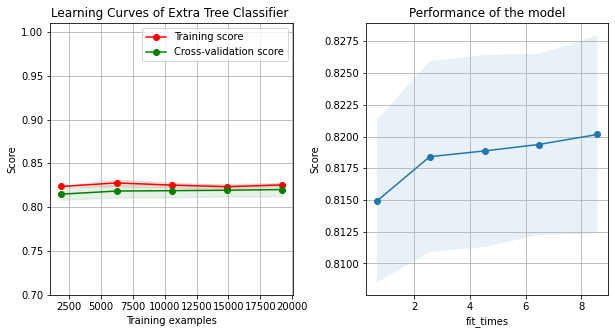

In [ ]:
title = "Learning Curves of Extra Tree Classifier "
plot_learning_curve(
    ext_clf_cv.best_estimator_, title, X_train_transformed,np.ravel(y_train), ylim=(0.7, 1.01), cv=StratifiedKFold(n_splits=5), n_jobs=4
)

The Generalisation gap between the training score and validation score is very minimal which tends to converge also at more training samples. It shows some good fit properties but then around convergence it seems the model tends to overfit also. It seems the Extra Tree model has more capacity than is required for the problem, and, in turn, too much flexibility. Such a case happens when the model has learned the training data way too much and so it becomes less capable to generalise new data.

###<font color='blue'>Analysis</font>

In [ ]:
analysis_report(y_test,y_pred_RF,'Random forest Classifier')

Confusion Matrix of Random forest Classifier: 
 [[4454  219]
 [ 857  470]]
Accuracy: 82.067 %
Recall/Sensitivity/True Positive Rate: 0.3542
Precision: 0.6821
F1 score: 0.466


In [ ]:
analysis_report(y_test,y_pred_EXT,'Extra Tree Classifier')

Confusion Matrix of Extra Tree Classifier: 
 [[4470  203]
 [ 869  458]]
Accuracy: 82.133 %
Recall/Sensitivity/True Positive Rate: 0.3451
Precision: 0.6929
F1 score: 0.461


In [ ]:
analysis_report(y_test,y_pred_ada3,'Ada Boost Classifier')

Confusion Matrix of Ada Boost Classifier: 
 [[4359  314]
 [ 878  449]]
Accuracy: 80.133 %
Recall/Sensitivity/True Positive Rate: 0.3384
Precision: 0.5885
F1 score: 0.43


In [ ]:
analysis_report(y_test,y_pred_GB,'Gradient Boosted Classifier')

Confusion Matrix of Gradient Boosted Classifier: 
 [[4440  233]
 [ 857  470]]
Accuracy: 81.833 %
Recall/Sensitivity/True Positive Rate: 0.3542
Precision: 0.6686
F1 score: 0.463


#<font color='blue'>Analysis</font>
###<font color='green'>Decision Tree comparisons</font>


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky">Confusion Matrix for 'criterion=entropy':</th>
    <th class="tg-0pky">Confusion Matrix for 'criterion=gini':</th>
    <th class="tg-0lax">Confusion Matrix with Randomised searchcv (criterion='gini')':</th>
    <th class="tg-0lax"></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">[[4457&nbsp;&nbsp;&nbsp;&nbsp;216]</td>
    <td class="tg-0pky">[[4465&nbsp;&nbsp;&nbsp;208]</td>
    <td class="tg-0lax">[[4459&nbsp;&nbsp;&nbsp;214]</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">[ 877&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;450]]</td>
    <td class="tg-0pky">[ 879&nbsp;&nbsp;&nbsp;&nbsp;448]]</td>
    <td class="tg-0lax">[ 877&nbsp;&nbsp;&nbsp;450]]</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Accuracy: 81.783 %</td>
    <td class="tg-0pky">Accuracy: 81.883 %</td>
    <td class="tg-0lax">Accuracy: 81.817 %</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Recall/Sensitivity/True Positive Rate: 0.3391</td>
    <td class="tg-0pky">Recall/Sensitivity/True Positive Rate: 0.3376</td>
    <td class="tg-0lax">Recall/Sensitivity/True Positive Rate: 0.3391</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Precision: 0.6757</td>
    <td class="tg-0pky">Precision: 0.6829</td>
    <td class="tg-0lax">Precision: 0.6777</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">F1 for Random Forest: 0.452</td>
    <td class="tg-0pky">F1 for Random Forest: 0.452</td>
    <td class="tg-0lax">F1 for Random Forest: 0.452</td>
    <td class="tg-0lax"></td>
  </tr>
</tbody>
</table>

As can be seen, we applied different parameters on decision tree classifier and also performed Randomised Search CV, however very little difference can be seen. As f1 score is pretty much same. For this credit card default scenario, our results should have both higher recall and precision.

###<font color='green'>Comparisons of Random Forest, Extra Tree, Ada Boost and Gradient Boost Classifiers</font>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky">Confusion Matrix of Random forest Classifier:</th>
    <th class="tg-0pky">Confusion Matrix of Extra Tree Classifier:</th>
    <th class="tg-0lax">Confusion Matrix of Ada Boost Classifier:</th>
    <th class="tg-0lax">Confusion Matrix of Gradient Boosted Classifier:</th>
    <th class="tg-0lax"></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">[[4454&nbsp;&nbsp;&nbsp;219]</td>
    <td class="tg-0pky">[[4470&nbsp;&nbsp;&nbsp;&nbsp;203]</td>
    <td class="tg-0lax">[[4359&nbsp;&nbsp;&nbsp;&nbsp;314]</td>
    <td class="tg-0lax">[[4440&nbsp;&nbsp;&nbsp;&nbsp;233]</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">[ 857&nbsp;&nbsp;&nbsp;470]]</td>
    <td class="tg-0pky">[ 869&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;458]]</td>
    <td class="tg-0lax">[ 878&nbsp;&nbsp;&nbsp;&nbsp;449]]</td>
    <td class="tg-0lax">[ 857&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;470]]</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Accuracy: 82.067 %</td>
    <td class="tg-0pky">Accuracy: 82.133 %</td>
    <td class="tg-0lax">Accuracy: 80.133 %</td>
    <td class="tg-0lax">Accuracy: 81.833 %</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Recall/Sensitivity/True Positive Rate: 0.3542</td>
    <td class="tg-0pky">Recall/Sensitivity/True Positive Rate: 0.3451</td>
    <td class="tg-0lax">Recall/Sensitivity/True Positive Rate: 0.3384</td>
    <td class="tg-0lax">Recall/Sensitivity/True Positive Rate: 0.3542</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Precision: 0.6821</td>
    <td class="tg-0pky">Precision: 0.6929</td>
    <td class="tg-0lax">Precision: 0.5885</td>
    <td class="tg-0lax">Precision: 0.6686</td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0pky">F1 score: 0.466</td>
    <td class="tg-0pky">F1 score: 0.461</td>
    <td class="tg-0lax">F1 score: 0.43</td>
    <td class="tg-0lax">F1 score: 0.463</td>
    <td class="tg-0lax"></td>
  </tr>
</tbody>
</table>

We can clearly see, Ada boost was the most inefficient in terms of its precision. Recall is still comparitively better and thus contributing towards its f1-Score, but this model resulted in most false negatives.

Both Random Forest and extra tree classifiers have the highest model accuracies with highest recalls and precisions.However as we see from the learning curves, it also shows underfits for random forest and overfit case for extra Tree. Gradient Boosted Tree classifier seems to have performed the best with high recalls, precisions and high f1-score. The learning curves depicts a great level of generalisation which shows its a good fit model for the credit card default study.

The main reason of success of Gradient boosted tree is also because this was a very unbalanced dataset and so instead of modifying the weight of the training instances at each step, gradient boosting will try to fit a new predictor to the residual errors made by the previous predictor.

The second best is Extra Tree Classifier and the reason for its success is that it reduces the biasness by reducing the variance more strongly than the weaker randomization schemes used by other methods. The model is able to fit a number of randomized decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy. Thats why we are able to see the highest precision by Extra tree classifier.